In [1]:
# 1. Sentiment Analysis

In [2]:
import os
import pandas as pd
from dotenv import load_dotenv
import nltk as nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from collections import Counter
from nltk import ngrams

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# The News API allows only a limited number of articles to be accessed each day.
from newsapi.newsapi_client import NewsApiClient
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import alpaca_trade_api as tradeapi

In [4]:
# Load .env enviroment variables
load_dotenv()

# Set News API Key
newsapi = NewsApiClient(api_key=os.environ["NEWS_API"])

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("alpaca_api_key")
alpaca_secret_key = os.getenv("alpaca_api_secret_key")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [5]:
# Set current date and the date from one month ago using the ISO format
from datetime import datetime, timedelta
current_date = pd.Timestamp(datetime.now(), tz="America/New_York").isoformat()
past_date = pd.Timestamp(datetime.now()- timedelta(30), tz="America/New_York").isoformat()

In [6]:
# Create function to get sentiments from a dictionary of articles from newsapi
def get_sentiments(dictionary):
    results = []
    for x in dictionary['articles']:
        title = x['title']
        text = x["content"]
        date = x["publishedAt"][:10]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment['compound']
        positive = sentiment['pos']
        neutral = sentiment['neu']
        negative = sentiment['neg']
        results.append({
            'Title': title,
            'Text': text,
            'Date': date,
            'Compound': compound,
            'Positive': positive,
            'Neutral': neutral,
            'Negative': negative
        })
    
    return pd.DataFrame(results)

In [7]:
# Fetch the Bitcoin news articles
btc_articles = newsapi.get_everything(q = 'Bitcoin', language = 'en')
len(btc_articles)

3

In [8]:
# Fetch the Ethereum news articles
eth_articles = newsapi.get_everything(q = 'Ethereum', language = 'en')
len(eth_articles)

3

In [9]:
# Create the Bitcoin sentiment scores DataFrame
btc_sentiments = get_sentiments(btc_articles)

In [10]:
# Create the Ethereum sentiment scores DataFrame
eth_sentiments = get_sentiments(eth_articles)

In [11]:
# Describe the Bitcoin Sentiment
btc_sentiments.describe()

,Compound,Positive,Neutral,Negative
count,20.000000,20.00000,20.000000,20.000000
mean,0.016455,0.05225,0.907250,0.040450
std,0.373168,0.06129,0.079594,0.054018
min,-0.612400,0.00000,0.705000,0.000000
25%,-0.300350,0.00000,0.840250,0.000000
50%,0.000000,0.02150,0.921500,0.000000
75%,0.202300,0.10575,0.967750,0.075500
max,0.726400,0.16900,1.000000,0.184000


In [12]:
# Describe the Ethereum Sentiment
eth_sentiments.describe()

,Compound,Positive,Neutral,Negative
count,20.000000,20.000000,20.000000,20.00000
mean,0.103765,0.048800,0.926550,0.02465
std,0.393588,0.064012,0.057397,0.03542
min,-0.381800,0.000000,0.806000,0.00000
25%,-0.317450,0.000000,0.918500,0.00000
50%,0.000000,0.000000,0.923000,0.00000
75%,0.371375,0.081500,0.961000,0.06500
max,0.771700,0.194000,1.000000,0.08000


In [13]:
# Bitcoin and Ethereum sentiment are both neutral over the past 30-days

# Questions:
# 1. Which coin had the highest mean positive score?
        # Ethereum had highest postive mean score of 0.103765
# 2. Which coin had the highest compound score?
        # Ethereum had highest compound score at 0.7717
# 3. Which coin had the highest positive score?
        # Ethereum had highest postive score at 0.1940

In [14]:
# 2. Natural Language Processing

In [15]:
# Tokenizer

In [16]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

In [18]:
# Create a list of stopwords
stopwords = set(stopwords.words('english'))

In [19]:
# Expand the default stopwords list if necessary
addon = {'bitcoi', 'char', 'u', 'el'}
sw = stopwords.union(addon)

In [20]:
# Tokenizes Text from DataFrame
def tokenizer(df):
    regex = re.compile("[^a-zA-Z]")
    df['Tokens'] = ""

    for i in range(len(df)):
        clean = regex.sub(" ", df['Text'].loc[i])
        words = word_tokenize(clean)
        words_lower = [x.lower() for x in words if x.lower() not in sw]
        words_lemmatized = [lemmatizer.lemmatize(x) for x in words_lower]
        df['Tokens'][i] = words_lemmatized
    
    return df

In [21]:
# new tokens column for Bitcoin
btc_tokenized = tokenizer(btc_sentiments)

<ipython-input-20-20bb629c1cbf>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tokens'][i] = words_lemmatized


In [22]:
# new tokens column for Ethereum
eth_tokenized = tokenizer(eth_sentiments)

<ipython-input-20-20bb629c1cbf>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tokens'][i] = words_lemmatized


In [23]:
# NGrams

In [24]:
# Generate the Bitcoin N-grams
btc_tokens = []
[btc_tokens.append(btc_tokenized['Tokens'][x]) for x in range(len(btc_tokenized))]
btc_tokens = [item for sublist in btc_tokens for item in sublist if item not in sw]
btc_ngrams = Counter(ngrams(btc_tokens, n = 2))

In [25]:
# Generate the Ethereum N-grams
eth_tokens = []
[eth_tokens.append(eth_tokenized['Tokens'][x]) for x in range(len(eth_tokenized))]
eth_tokens = [item for sublist in eth_tokens for item in sublist if item not in sw]
eth_ngrams = Counter(ngrams(eth_tokens, n = 2))

In [26]:
# Function token_count generates the top 10 words for a given coin
def token_count(tokens, N=10):
    "Returns the top N tokens from the frequency count"
    return Counter(tokens).most_common(N)

In [27]:
# top 10 words for Bitcoin
token_count(btc_tokens)

[('bitcoin', 22),
 ('reuters', 20),
 ('june', 10),
 ('cryptocurrency', 7),
 ('illustration', 6),
 ('salvador', 6),
 ('tesla', 5),
 ('monday', 5),
 ('world', 4),
 ('legal', 4)]

In [28]:
# top 10 words for Ethereum
token_count(eth_tokens)

[('bitcoin', 17),
 ('cryptocurrency', 13),
 ('reuters', 12),
 ('ethereum', 9),
 ('june', 8),
 ('world', 8),
 ('network', 7),
 ('biggest', 6),
 ('losing', 5),
 ('previous', 5)]

In [29]:
# Word Clouds

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

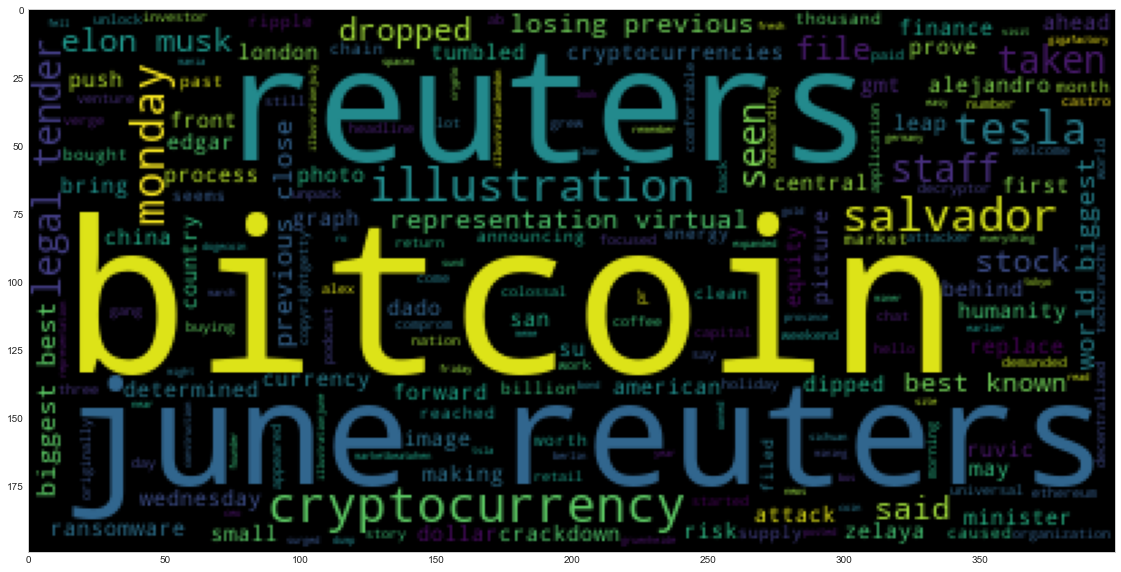

In [31]:
# Generate the Bitcoin word cloud
big_string = ' '.join(btc_tokens)
wc = WordCloud().generate(big_string)
plt.grid(b = None)
plt.imshow(wc)

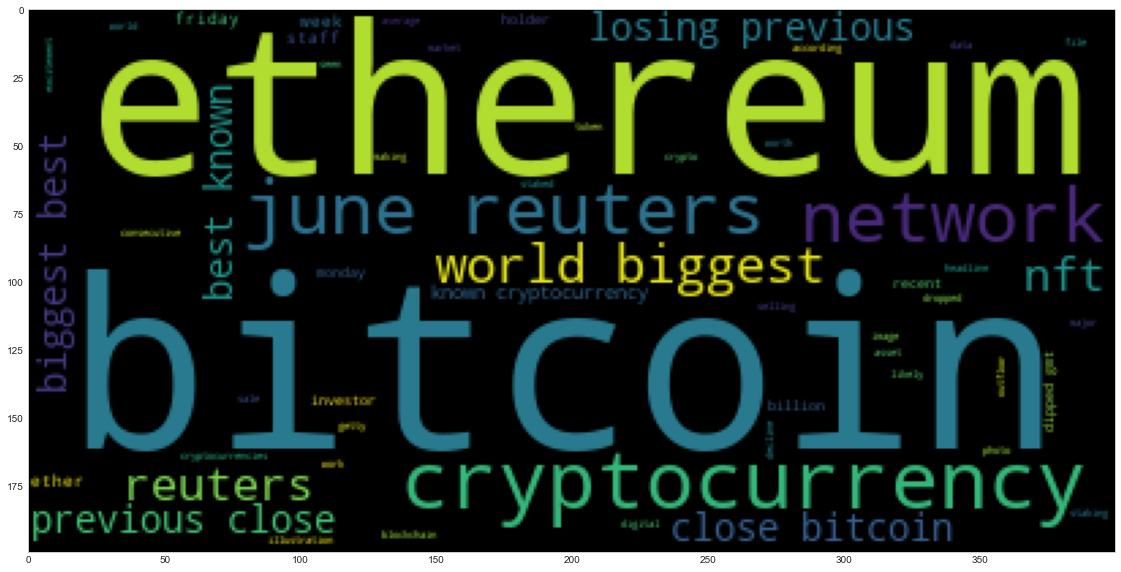

In [32]:
# Ethereum word cloud
big_string = ' '.join(eth_tokens)
wc = WordCloud().generate(big_string)
plt.grid(b = None)
plt.imshow(wc)

In [33]:
# 3. Named Entity Recognition

In [34]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [35]:
# Concatenate btc text
btc_text = ' '.join(btc_sentiments['Text'])

In [36]:
# Run the NER processor on all of the text
btc_doc = nlp(btc_text)
# Add a title to the document
btc_doc.user_data["title"] = "BTC Text Recognition"

In [37]:
displacy.render(btc_doc, style = 'ent')

In [38]:
# List all Entities
[(x.text, x.label_) for x in btc_doc.ents]

[('Elon Musk', 'PERSON'),
 ('Tesla', 'PERSON'),
 ('the past few months', 'DATE'),
 ('first', 'ORDINAL'),
 ('Tesla', 'ORG'),
 ('$1.5 billion', 'MONEY'),
 ('Alex Castro', 'PERSON'),
 ('Verge', 'ORG'),
 ('Three days', 'DATE'),
 ('the holiday weekend', 'DATE'),
 ('$70m', 'MONEY'),
 ('£50.5m', 'MONEY'),
 ('Bitcoin', 'PERSON'),
 ('Bitcoin and Ethereum', 'ORG'),
 ('2021', 'DATE'),
 ('June 16', 'DATE'),
 ('Reuters', 'ORG'),
 ('El Salvador', 'GPE'),
 ('U.S.', 'GPE'),
 ('Finance', 'ORG'),
 ('Alejandro Zelaya', 'PERSON'),
 ('Wednesday', 'DATE'),
 ('Central American', 'NORP'),
 ('LONDON', 'GPE'),
 ('June 23', 'DATE'),
 ('Reuters', 'ORG'),
 ('El Salvador', 'GPE'),
 ('LONDON', 'GPE'),
 ('June 23', 'DATE'),
 ('Reuters', 'ORG'),
 ('El Salvador', 'GPE'),
 ('Pr', 'PERSON'),
 ('Reuters', 'ORG'),
 ('Reuters', 'ORG'),
 ('El Salvador', 'GPE'),
 ('U.S.', 'GPE'),
 ('Finance', 'ORG'),
 ('Alejandro Zelaya', 'PERSON'),
 ('Wednesday', 'DATE'),
 ('the Central American', 'LOC'),
 ('Monday', 'DATE'),
 ('morning', 'T

In [39]:
# Concatenate ETH text 
eth_text = ' '.join(eth_sentiments['Text'])

In [40]:
# Run the NER processor on all of the text
eth_doc = nlp(eth_text)
# Add a title to the document
eth_doc.user_data['title'] = "ETH Text Recognition"

In [41]:
# Render the visualization
displacy.render(eth_doc, style = 'ent')

In [42]:
# List all Entities
[(x.text, x.label_) for x in eth_doc.ents]

[('21.25', 'MONEY'),
 ('June 17', 'DATE'),
 ('97%', 'PERCENT'),
 ('Bitcoin and Ethereum', 'ORG'),
 ('2021', 'DATE'),
 ('NFT', 'ORG'),
 ('hundreds of thousands', 'CARDINAL'),
 ('Yuriko Nakao', 'PERSON'),
 ('Friday', 'DATE'),
 ('more than $13 billion', 'MONEY'),
 ('2.0', 'CARDINAL'),
 ('Photothek/Getty Images', 'PERSON'),
 ('more than $13 billion', 'MONEY'),
 ('2.0', 'CARDINAL'),
 ('$40 billion', 'MONEY'),
 ('2025', 'DATE'),
 ('JPMorgan', 'ORG'),
 ('Tim Berners-Lee', 'PERSON'),
 ('NFT', 'ORG'),
 ("Sotheby's", 'ORG'),
 ('NFT', 'ORG'),
 ('Two', 'CARDINAL'),
 ('Keep Network', 'ORG'),
 ('Last week', 'DATE'),
 ('NFT', 'ORG'),
 ('as much as', 'CARDINAL'),
 ('90 percent', 'PERCENT'),
 ('recent weeks', 'DATE'),
 ('recent months', 'DATE'),
 ('Getty Images\r\nInvestors', 'ORG'),
 ('the third week', 'DATE'),
 ('February 2018', 'DATE'),
 ('Reuters', 'ORG'),
 ('June 25', 'DATE'),
 ('Reuters', 'ORG'),
 ('7.37%', 'PERCENT'),
 ('32,094.44', 'MONEY'),
 ('Friday', 'DATE'),
 ('2,554.88', 'MONEY'),
 ('Bitco